In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime
import inspect
from utils.constants import *
from datetime import datetime
import math
import statistics
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs


In [2]:
# %store data

In [3]:
%store -r

In [4]:
repository = DataRepository()

Connected to MySQL Server version  5.7.39-42-log


### Configuration

The configuration defines under what circumstances the experiment was executed under.

In [5]:
# CONFIGURATION
min_temp = 0
max_temp = 200

min_battery = 40
max_battery = 80

between = 0
duration = 1

special_between = {
    WINDOWS_OS : {
        CLAMP : 1
    }
}

language = "CSharp"

env = "PROD"

limit = 200

### Operating System

Here the different operation systems used in the experiments are defined

In [6]:
## OS
os = [
    WINDOWS_OS,
    LINUX_OS
]

short_os = {
    WINDOWS_OS : "win",
    LINUX_OS : "lin"
}

### Test Cases

Here the different test cases executed during the experiments are defined

In [7]:
## Test cases
test_cases = [
    IDLE_CASE,
    # DINING_PHILOSOPHERS,
    BINARY_TREE,
    # REVERSE_COMPLEMENT
    FANNKUCH_REDUX,
    NBODY,
    FASTA
]

short_test_case = {
    IDLE_CASE : "idle",
    DINING_PHILOSOPHERS : "din",
    BINARY_TREE : "bin",
    REVERSE_COMPLEMENT : "rev",
    FANNKUCH_REDUX : "fann",
    NBODY : "nbody",
    FASTA : "fasta"
}

### Profilers

Here the different profilers used to measure the energy consumption of the test cases are defined

In [8]:
## Profilers
profilers = [
    INTEL_POWER_GADGET,
    RAPL,
    HARDWARE_MONITOR,
    CLAMP,
    E3
]

short_profilers = {
    INTEL_POWER_GADGET : "IPG",
    RAPL : "RA",
    HARDWARE_MONITOR : "HWM",
    E3 : "E3",
    CLAMP : "CL"
}

### DUT

Here the different Devices Under Tests (DUT) are defined

In [9]:
## DUT
duts = [
    SURFACE_4_PRO,
    SURFACE_BOOK,
    POWER_KOMPLETT
]

short_duts = {
    SURFACE_4_PRO : "pro",
    SURFACE_BOOK : "book",
    POWER_KOMPLETT : "pow",
}

dut_version = {
    SURFACE_BOOK : {
            WINDOWS_OS : 6,
            LINUX_OS : 3
        },
    SURFACE_4_PRO : {
        WINDOWS_OS : 12,
        LINUX_OS : 2,
    },
    POWER_KOMPLETT : {
        WINDOWS_OS : 8,
        LINUX_OS : 1,
    }
}

### Types

Here the different types of energy measurements are defined

In [10]:
## Types
comparison_types = [PACKAGE_TOTAL, DRAM_TOTAL,CORE_TOTAL]


In [11]:
def get_dynamic_energy(
    d, o, p, energy_type, duration, energy_consumption, dynamic_energy, per_unit=1000
):
    dynamic_energy_index = dynamic_energy[d][o][p]

    dynamic_energy_consumption = dynamic_energy_index[energy_type]
    dynamic_duration = dynamic_energy_index["duration"]

    if dynamic_duration == 0 or duration == 0:
        return 0

    dynamic_energy_per_unit = (per_unit / dynamic_duration) * dynamic_energy_consumption
    energy_per_unit = (per_unit / duration) * energy_consumption

    return energy_per_unit - dynamic_energy_per_unit

In [12]:
def default_func(exp, value):
    return True


def get_consumption(
    d,
    o,
    p,
    t,
    value_type,
    func_parameter,
    data,
    dynamic_energy,
    func=default_func,
    get_dynamic=True,
):
    try:
        data_points = data[d][o][t][p]["experiment"].experiments
    except Exception as e:
        return 0, 0, 0, 0, 0, 0

    duration = [
        exp.duration / exp.runs for exp in data_points if func(exp, func_parameter)
    ]
    length = len(duration)

    if value_type == PACKAGE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(x.TrueRMS, x.duration) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerPacketTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.PSysStopInJoules - x.PSysStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == DRAM_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeDramEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(0, 0) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerMemoryTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.DramStopInJoules - x.DramStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == CORE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [
                (x.TrueRMS, x.duration) for x in data_points if func(x, func_parameter)
            ]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerCoresTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.CoreStopInJoules - x.CoreStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    else:
        raise Exception(f"{value_type} not implmeneted")

    if get_dynamic:
        dynamic_values = []

        for value in values:
            dynamic_values.append(
                get_dynamic_energy(d, o, p, value_type, value[1], value[0], dynamic_energy)
            )

        if length == 0:
            return 0, 0, 0, 0, 0, 0

        return (
            length,
            sum(dynamic_values) / length,
            np.std(dynamic_values),
            min(dynamic_values),
            max(dynamic_values),
            sum(duration) / length,
        )
    else:
        only_values = [x[0] for x in values]
        return (
            length,
            sum(only_values) / length,
            np.std(only_values),
            min(only_values),
            max(only_values),
            sum(duration) / length,
        )

In [13]:
def initialize_dynamic_energy(data):
    dynamic_energy = {}
    for d in duts:
        dynamic_energy[d] = {}
        for o in os:
            dynamic_energy[d][o] = {}
            for p in profilers:
                dynamic_energy[d][o][p] = {}
                for types in comparison_types:
                    t = IDLE_CASE
                    
                    count, average, _, min_value, max_value, duration = get_consumption(
                        d, o, p, t, types, "", data, dynamic_energy, get_dynamic=False)
                    dynamic_energy[d][o][p][types] = average
                    dynamic_energy[d][o][p]["duration"] = duration
                    
                    print(f"{d} - {o} - {p} - {t} - {types} - {average} - {count} - {min_value} - {max_value} - {duration}")
    return dynamic_energy

In [14]:
def is_correct_first_profiler(exp, value):
    return exp.first_profiler == value

def plot_first_profiler_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    x = []
    y = []
    e = []

    i = 0

    for d in duts:
        for t in test_cases:
            if t != IDLE_CASE:
                for o in os:
                    for p in profilers:
                        for first_profiler in profilers:
                            length, average, std, min_value, max_value, duration = get_consumption(d, o, p, t, comparison_type, first_profiler, data, dynamic_energy, func=is_correct_first_profiler)
                            
                            if not min_value == 0 and not max_value == 0:
                                x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                y.append(average)
                                e.append(std)
                                
                                # print(f"{i} - {first_profiler}, {p}, {d}, {o}, {t} - sum of {length} ({min_value} - {max_value})")
                                print(f"{i} - {d}, {t}, {o}, {p}, {first_profiler} - sum of {length} ({min_value} - {max_value})")
                                i += 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 90)
    plt.errorbar(x, y, e, linestyle='None', marker='.')
    plt.ylim(0,ylim_max)
    plt.show()

In [15]:
def get_dynamic_energy(d, o, p, energy_type, duration, energy_consumption, dynamic_energy, per_unit=1000):
    dynamic_energy_index = dynamic_energy[d][o][p]

    dynamic_energy_consumption = dynamic_energy_index[energy_type]
    dynamic_duration = dynamic_energy_index["duration"]
    
    if dynamic_duration == 0 or duration == 0:
        return 0
    
    dynamic_energy_per_unit = (per_unit / dynamic_duration) * dynamic_energy_consumption
    energy_per_unit = (per_unit / duration) * energy_consumption
    
    return energy_per_unit - dynamic_energy_per_unit 

In [16]:
def plot_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100, get_dynamic=True):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    energy_consumption = []
    
    x = []
    y = []
    e = []


    i = 0

    for t in test_cases:
        if t != IDLE_CASE:
            for d in duts:
                for o in os:
                    for p in profilers:
                        if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                            length, average, std, min_value, max_value, duration = get_consumption(d, o, p, t, comparison_type, "", data, dynamic_energy, get_dynamic=get_dynamic)
                            
                            if length > 0:
                                energy_consumption.append(average)
                                x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                y.append(average)
                                e.append(std)
                                
                                print(f"{i} - {d}, {o}, {p}, {t} - sum of {length} ({min_value} - {max_value})")
                                i += 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    plt.errorbar(x, y, e, linestyle='None', marker='.')
    ax.tick_params(axis='x', labelrotation = 90)
    plt.ylim(0,ylim_max)
    
    plt.show()

In [17]:
def plot_iterations(comparison_type, get_next_value, is_correct_value, xlabel, ylabel, label, data, dynamic_energy, used_duts = duts, used_test_cases = test_cases):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    for d in used_duts:
        for t in used_test_cases:
            if t != IDLE_CASE:
                for o in os:
                    for p in profilers:
                        if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                            x1 = []
                            y1 = []
                            avg_len = []
                            for i in get_next_value():
                                length, average, _, min_value, max_value, _ = get_consumption(d, o, p, t, comparison_type, i, data, dynamic_energy, func=is_correct_value)
                                
                                
                                if length > 0:
                                    avg_len.append(length)
                                    if isinstance(i, tuple) or isinstance(i, list):
                                        x1.append(i[0])
                                    else:
                                        x1.append(i)
                                    y1.append(average)
                            if len(x1) > 0:
                                print(f"{d} - {t} - {o} - {p} - avg {sum(avg_len) / len(avg_len)} ({min(avg_len)}, {max(avg_len)})")
                                plt.plot(x1, y1, label = f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    plt.legend()
    plt.show()

### Datainitialization

The data for the experiments will be fetched from the database and stored in a dictionary, in the order as can be seen below:

```python
data[current_dut][current_os][current_test_case][current_profiler]
```

In [18]:
# data = repository.get_experiments(
#         duts,
#         os,
#         test_cases,
#         profilers,
#         dut_version,
#         min_temp,
#         max_temp,
#         min_battery,
#         max_battery,
#         duration,
#         between,
#         env,
#         language,
#         special_between
#     )

In [19]:
repository.close()

In [20]:
# a = data[SURFACE_BOOK][WINDOWS_OS][FANNKUCH_REDUX][HARDWARE_MONITOR]["experiment"]
# inspect.getmembers(a, lambda a:not(inspect.isroutine(a)))


In [21]:
exp = data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0]
# inspect.getmembers(exp, lambda a:not(inspect.isroutine(a)))

### Dynamic Energy

Next up, the dynamic energy will be calculated. This will be the average energy consumption of the idle case.

In [22]:
dynamic_energy = initialize_dynamic_energy(data)

Surface4Pro - Win32NT - IntelPowerGadget - TestCaseIdle - PackageInJoulesTotal - 95.98967627941177 - 136 - 61.139404 - 667.71844 - 30086.066176470587
Surface4Pro - Win32NT - IntelPowerGadget - TestCaseIdle - DramInJoulesTotal - 29.535156249999986 - 136 - 29.281921 - 33.59204 - 30086.066176470587
Surface4Pro - Win32NT - IntelPowerGadget - TestCaseIdle - CoresInJoulesTotal - 95.98967627941177 - 136 - 61.139404 - 667.71844 - 30086.066176470587
Surface4Pro - Win32NT - RAPL - TestCaseIdle - PackageInJoulesTotal - 0 - 0 - 0 - 0 - 0
Surface4Pro - Win32NT - RAPL - TestCaseIdle - DramInJoulesTotal - 0 - 0 - 0 - 0 - 0
Surface4Pro - Win32NT - RAPL - TestCaseIdle - CoresInJoulesTotal - 0 - 0 - 0 - 0 - 0
Surface4Pro - Win32NT - HardwareMonitor - TestCaseIdle - PackageInJoulesTotal - 49.71980046196019 - 136 - 23.602422580122948 - 398.4910373315215 - 30051.625
Surface4Pro - Win32NT - HardwareMonitor - TestCaseIdle - DramInJoulesTotal - 28.59632083948921 - 136 - 28.377602443099022 - 29.667289569973946

### Dynamic Energy Example

An example of how the dynamic energy consumption is calculated can be seen below.

In [23]:
dynamic_energy_dut = SURFACE_4_PRO
dynamic_energy_os = LINUX_OS
dynamic_energy_profiler = RAPL
dynamic_energy_test_case = IDLE_CASE
dynamic_energy_type = CORE_TOTAL

In [24]:
_, energy_consumption, _, _, _, duration = get_consumption(dynamic_energy_dut, 
                                                                    dynamic_energy_os, 
                                                                    dynamic_energy_profiler, 
                                                                    dynamic_energy_test_case, 
                                                                    dynamic_energy_type, "", 
                                                                    data,
                                                                    dynamic_energy, get_dynamic=False)

dynamic_energy_consumption = get_dynamic_energy(dynamic_energy_dut, 
                                                dynamic_energy_os, 
                                                dynamic_energy_profiler, 
                                                dynamic_energy_type, 
                                                duration, 
                                                energy_consumption,
                                                dynamic_energy)
# dynamic_energy_consumption = get_dynamic_energy(d, v, o, p, dynamic_energy_type, duration, energy_consumption, per_unit=0.5716669904816651)

energy_consumption, duration, dynamic_energy_consumption

(278.1936404666668, 30023.616666666665, 0.0)

In [25]:
# data_to_inspect = data[power_komplett][windows_os][idle_case][intel_power_gadget]["experiment"].experiments[0].start_battery.data
# inspect.getmembers(data_to_inspect, lambda a:not(inspect.isroutine(a)))

### Intel Power Gadget

- CumulativeDramEnergyInJoules
- CumulativeGtEnergyInJoules
- CumulativeIaEnergyInJoules
- CumulativeProcessorEnergyInJoules

### Clamp

- TrueRMS
- ACRMSRAW

idle -  true: 3651, acr: 3612
fans - 600 - 700

### OpenHardwareMonitor

- cpuPowerPacketTotalJ
- cpuPowerCoresTotalJ
- cpuPowerMemoryTotalJ
- cpuPowerPacketAverageJ
- cpuPowerCoresAverageJ
- cpuPowerMemoryAverageJ

### Dynamic energy consumption

A graph comparing the package measuring made by different measuring instruments on the different DUTs

In [26]:
dynamic_energy[SURFACE_4_PRO][WINDOWS_OS]

{'IntelPowerGadget': {'PackageInJoulesTotal': 95.98967627941177,
  'duration': 30086.066176470587,
  'DramInJoulesTotal': 29.535156249999986,
  'CoresInJoulesTotal': 95.98967627941177},
 'RAPL': {'PackageInJoulesTotal': 0,
  'duration': 0,
  'DramInJoulesTotal': 0,
  'CoresInJoulesTotal': 0},
 'HardwareMonitor': {'PackageInJoulesTotal': 49.71980046196019,
  'duration': 30051.625,
  'DramInJoulesTotal': 28.59632083948921,
  'CoresInJoulesTotal': 28.508995084239253},
 'Clamp': {'PackageInJoulesTotal': 0,
  'duration': 0,
  'DramInJoulesTotal': 0,
  'CoresInJoulesTotal': 0},
 'E3': {'PackageInJoulesTotal': 0,
  'duration': 0,
  'DramInJoulesTotal': 0,
  'CoresInJoulesTotal': 0}}

0 - Surface4Pro, Win32NT, IntelPowerGadget, BinaryTrees - sum of 122 (9.699561483966681 - 12.75021977515838)
1 - Surface4Pro, Win32NT, HardwareMonitor, BinaryTrees - sum of 124 (11.157781461498026 - 14.11880520188684)
2 - Surface4Pro, Unix, RAPL, BinaryTrees - sum of 120 (-139.23340883669562 - 235.69549494571976)
3 - SurfaceBook, Win32NT, IntelPowerGadget, BinaryTrees - sum of 127 (1.2670762584725308 - 5.172539407748209)
4 - SurfaceBook, Win32NT, HardwareMonitor, BinaryTrees - sum of 126 (1.515940938912102 - 6.473499540147198)
5 - SurfaceBook, Unix, RAPL, BinaryTrees - sum of 124 (-103.34858769225805 - 49.27413220973273)
6 - PowerKomplett, Win32NT, IntelPowerGadget, BinaryTrees - sum of 120 (62.628393540093064 - 68.65525045290848)
7 - PowerKomplett, Win32NT, HardwareMonitor, BinaryTrees - sum of 120 (63.17983995511292 - 67.2996179398815)
8 - Surface4Pro, Win32NT, IntelPowerGadget, FannkuchRedux - sum of 123 (10.216797824150543 - 14.374135610724714)
9 - Surface4Pro, Win32NT, HardwareMon

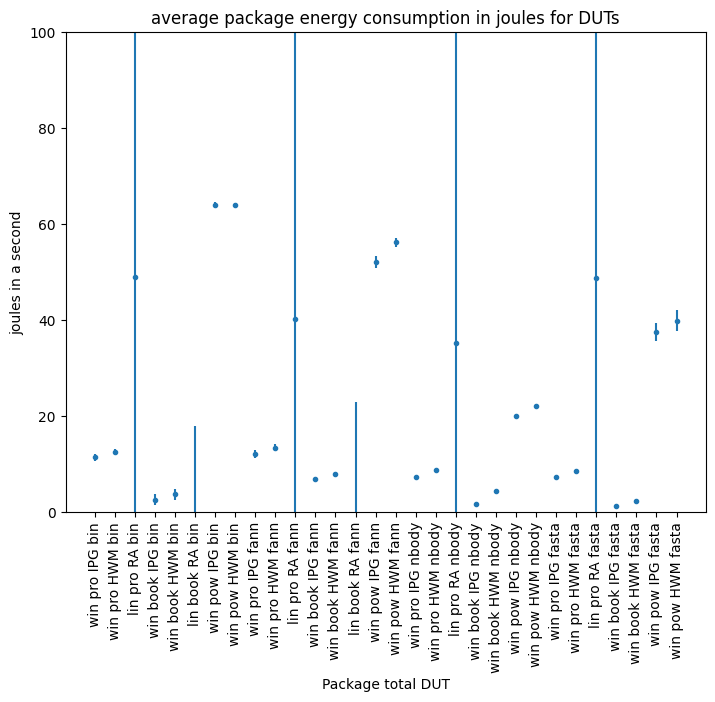

In [27]:
plot_comparison(PACKAGE_TOTAL, data, dynamic_energy, "Package total DUT", "joules in a second", "average package energy consumption in joules for DUTs")


### Dynamic energy consumption

A graph comparing the dram measuring made by different measuring instruments on the different DUTs

0 - Surface4Pro, Win32NT, IntelPowerGadget, BinaryTrees - sum of 122 (29.398438 - 49.166504)
1 - Surface4Pro, Win32NT, HardwareMonitor, BinaryTrees - sum of 124 (28.51812593638897 - 50.40746530890465)
2 - Surface4Pro, Unix, RAPL, BinaryTrees - sum of 120 (232.78010500000005 - 20826.508147)
3 - SurfaceBook, Win32NT, IntelPowerGadget, BinaryTrees - sum of 127 (47.215942 - 58.89435)
4 - SurfaceBook, Win32NT, HardwareMonitor, BinaryTrees - sum of 126 (43.93509164452553 - 56.482580721378326)
5 - SurfaceBook, Unix, RAPL, BinaryTrees - sum of 124 (-18.954357999999957 - 7928.023894)
6 - PowerKomplett, Win32NT, IntelPowerGadget, BinaryTrees - sum of 120 (38.161255 - 63.57312)
7 - PowerKomplett, Win32NT, HardwareMonitor, BinaryTrees - sum of 120 (37.57831805944443 - 43.440777480602264)
8 - Surface4Pro, Win32NT, IntelPowerGadget, FannkuchRedux - sum of 123 (30.026428 - 38.983093)
9 - Surface4Pro, Win32NT, HardwareMonitor, FannkuchRedux - sum of 122 (28.989911407232285 - 37.77821096777916)
10 - Su

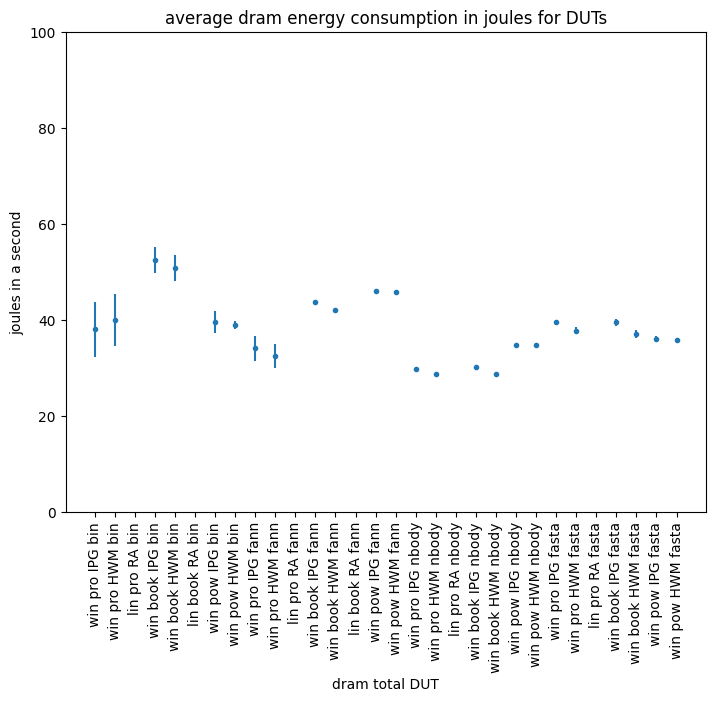

In [28]:
plot_comparison(DRAM_TOTAL,
                data,
                dynamic_energy,
                "dram total DUT",
                "joules in a second",
                "average dram energy consumption in joules for DUTs",
                get_dynamic=False)

### Dynamic energy consumption

A graph comparing the core measuring made by different measuring instruments on the different DUTs

0 - Surface4Pro, Win32NT, IntelPowerGadget, BinaryTrees - sum of 122 (9.699561483966681 - 12.75021977515838)
1 - Surface4Pro, Win32NT, HardwareMonitor, BinaryTrees - sum of 124 (10.844334061388246 - 12.222616294821524)
2 - Surface4Pro, Unix, RAPL, BinaryTrees - sum of 120 (3.223889902258742 - 3.4812917436448103)
3 - SurfaceBook, Win32NT, IntelPowerGadget, BinaryTrees - sum of 127 (1.2670762584725308 - 5.172539407748209)
4 - SurfaceBook, Win32NT, HardwareMonitor, BinaryTrees - sum of 126 (1.3133641767411408 - 6.213910783042094)
5 - SurfaceBook, Unix, RAPL, BinaryTrees - sum of 124 (1.1675513746723913 - 1.9653393865390365)
6 - PowerKomplett, Win32NT, IntelPowerGadget, BinaryTrees - sum of 120 (62.628393540093064 - 68.65525045290848)
7 - PowerKomplett, Win32NT, HardwareMonitor, BinaryTrees - sum of 120 (64.08669133730693 - 68.19130097703922)
8 - Surface4Pro, Win32NT, IntelPowerGadget, FannkuchRedux - sum of 123 (10.216797824150543 - 14.374135610724714)
9 - Surface4Pro, Win32NT, HardwareMo

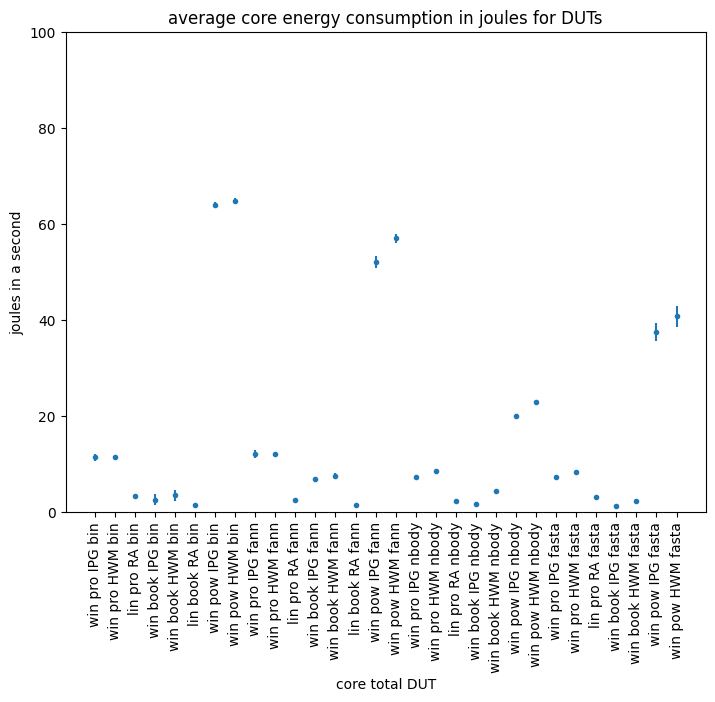

In [29]:
plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs")


### How R3 validation affects the energy consumtion

A graph presenting the the effect of which profiler was the first one to execute upon startup

0 - Surface4Pro, BinaryTrees, Win32NT, IntelPowerGadget, IntelPowerGadget - sum of 68 (9.699561483966681 - 12.75021977515838)
1 - Surface4Pro, BinaryTrees, Win32NT, IntelPowerGadget, HardwareMonitor - sum of 54 (10.209023847793171 - 12.744318013314507)
2 - Surface4Pro, BinaryTrees, Win32NT, HardwareMonitor, IntelPowerGadget - sum of 67 (11.677571651488847 - 14.027043029580954)
3 - Surface4Pro, BinaryTrees, Win32NT, HardwareMonitor, HardwareMonitor - sum of 57 (11.157781461498026 - 14.11880520188684)
4 - Surface4Pro, BinaryTrees, Unix, RAPL, RAPL - sum of 120 (-139.23340883669562 - 235.69549494571976)
5 - Surface4Pro, FannkuchRedux, Win32NT, IntelPowerGadget, IntelPowerGadget - sum of 71 (10.216797824150543 - 13.50088869103229)
6 - Surface4Pro, FannkuchRedux, Win32NT, IntelPowerGadget, HardwareMonitor - sum of 52 (10.797913789521896 - 14.374135610724714)
7 - Surface4Pro, FannkuchRedux, Win32NT, HardwareMonitor, IntelPowerGadget - sum of 69 (11.87229970813166 - 14.580479509329356)
8 - Su

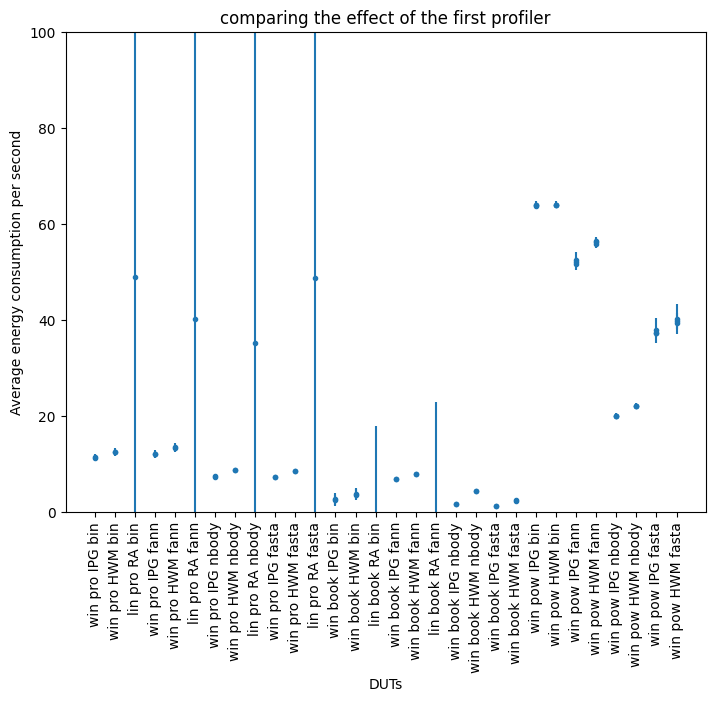

In [30]:
plot_first_profiler_comparison(PACKAGE_TOTAL, data, dynamic_energy, "DUTs", "Average energy consumption per second", "comparing the effect of the first profiler")

In [31]:
def get_iteration():
    for i in range(30):
        yield i
        
def is_correct_iteration(exp, value):
    return exp.iteration == value

### How time passed since a restart effects energy consumptionn

A graph presenting the relationship between the iteration since a system restart, and how it affects the energy consumption

Surface4Pro - BinaryTrees - Win32NT - IntelPowerGadget - avg 6.1 (1, 7)
Surface4Pro - BinaryTrees - Win32NT - HardwareMonitor - avg 6.2 (1, 7)
Surface4Pro - BinaryTrees - Unix - RAPL - avg 4.0 (4, 4)
Surface4Pro - FannkuchRedux - Win32NT - IntelPowerGadget - avg 6.833333333333333 (4, 7)
Surface4Pro - FannkuchRedux - Win32NT - HardwareMonitor - avg 6.777777777777778 (3, 7)
Surface4Pro - FannkuchRedux - Unix - RAPL - avg 4.0 (4, 4)
Surface4Pro - Nbody - Win32NT - IntelPowerGadget - avg 4.8 (3, 6)
Surface4Pro - Nbody - Win32NT - HardwareMonitor - avg 4.88 (3, 6)
Surface4Pro - Nbody - Unix - RAPL - avg 4.0 (4, 4)
Surface4Pro - Fasta - Win32NT - IntelPowerGadget - avg 5.708333333333333 (1, 6)
Surface4Pro - Fasta - Win32NT - HardwareMonitor - avg 5.913043478260869 (4, 6)
Surface4Pro - Fasta - Unix - RAPL - avg 1.0 (1, 1)


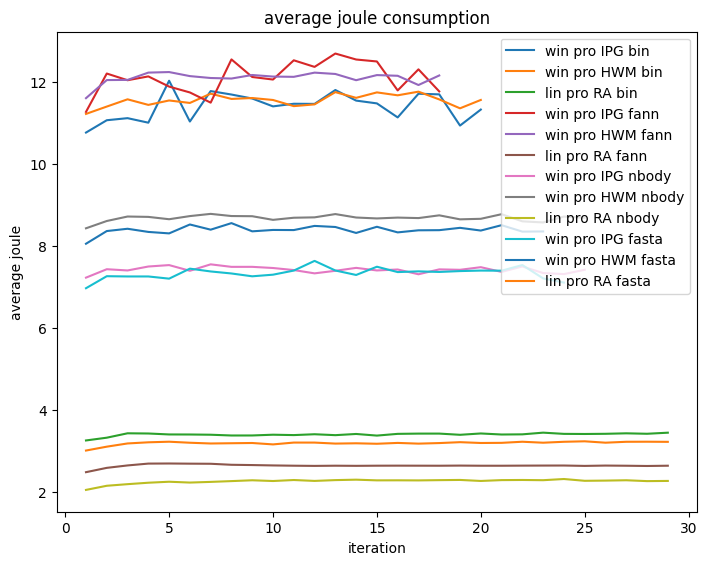

In [32]:
used_duts = [SURFACE_4_PRO]
used_test_cases = test_cases ##[FASTA]

plot_iterations(CORE_TOTAL,
                get_iteration,
                is_correct_iteration,
                "iteration",
                "average joule",
                "average joule consumption",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases = used_test_cases)

In [33]:
def get_buckets():
    min_bucket = 0
    max_bucket = 100
    bucket_size = 5

    last_value = 0

    for i in range(min_bucket + bucket_size, max_bucket + 1, bucket_size):
        # print(f"min: {last_value}, max: {i}, between: {((i - last_value) / 2) + last_value}")
        yield (last_value, i)
        last_value = i

def is_correct_temperature(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_temperature.data]
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp > min_value and avg_temp < max_value

### Temperatures levels effect on energy consumption

A graph presenting the relationship between the temperature and energy consumption

Surface4Pro - BinaryTrees - Win32NT - IntelPowerGadget - avg 21.8 (1, 80)
Surface4Pro - BinaryTrees - Win32NT - HardwareMonitor - avg 18.666666666666668 (1, 88)
Surface4Pro - BinaryTrees - Unix - RAPL - avg 20.4 (2, 79)
Surface4Pro - FannkuchRedux - Win32NT - IntelPowerGadget - avg 18.5 (1, 73)
Surface4Pro - FannkuchRedux - Win32NT - HardwareMonitor - avg 23.0 (3, 84)
Surface4Pro - FannkuchRedux - Unix - RAPL - avg 15.6 (2, 42)
Surface4Pro - Nbody - Win32NT - IntelPowerGadget - avg 22.4 (2, 89)
Surface4Pro - Nbody - Win32NT - HardwareMonitor - avg 29.0 (3, 91)
Surface4Pro - Nbody - Unix - RAPL - avg 13.833333333333334 (1, 38)
Surface4Pro - Fasta - Win32NT - IntelPowerGadget - avg 24.4 (1, 96)
Surface4Pro - Fasta - Win32NT - HardwareMonitor - avg 24.0 (1, 92)
Surface4Pro - Fasta - Unix - RAPL - avg 7.666666666666667 (1, 19)


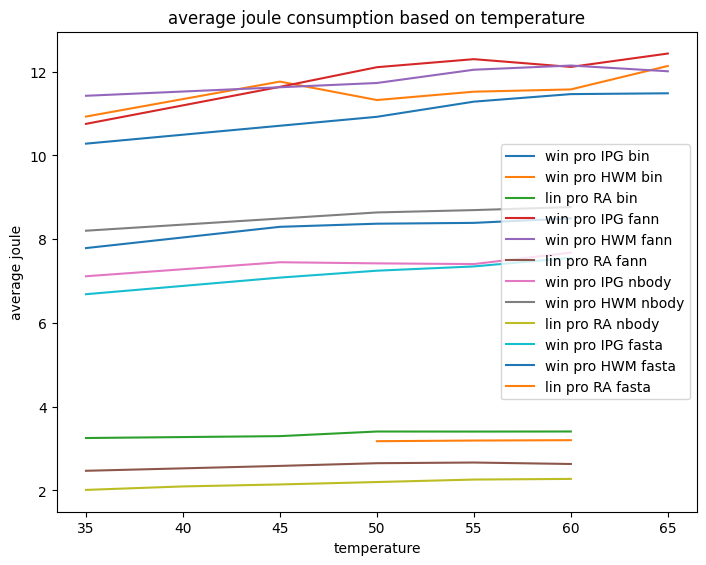

In [34]:
used_duts = [SURFACE_4_PRO]
used_test_cases = test_cases

plot_iterations(CORE_TOTAL,
                get_buckets,
                is_correct_temperature,
                "temperature",
                "average joule",
                "average joule consumption based on temperature",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases=used_test_cases)

In [35]:
def is_correct_charge(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_battery.data]
    
    if len(temp) == 0:
        return False
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp >= min_value and avg_temp < max_value

### Battery levels effect on energy consumption

A graph presenting the relationship between the battery level and energy consumption

Surface4Pro - BinaryTrees - Win32NT - IntelPowerGadget - avg 13.555555555555555 (5, 18)
Surface4Pro - BinaryTrees - Win32NT - HardwareMonitor - avg 13.777777777777779 (6, 18)
Surface4Pro - BinaryTrees - Unix - RAPL - avg 15.0 (8, 19)
Surface4Pro - FannkuchRedux - Win32NT - IntelPowerGadget - avg 13.666666666666666 (4, 18)
Surface4Pro - FannkuchRedux - Win32NT - HardwareMonitor - avg 13.555555555555555 (3, 17)
Surface4Pro - FannkuchRedux - Unix - RAPL - avg 15.0 (2, 19)
Surface4Pro - Nbody - Win32NT - IntelPowerGadget - avg 13.333333333333334 (6, 21)
Surface4Pro - Nbody - Win32NT - HardwareMonitor - avg 13.555555555555555 (5, 21)
Surface4Pro - Nbody - Unix - RAPL - avg 17.142857142857142 (10, 20)
Surface4Pro - Fasta - Win32NT - IntelPowerGadget - avg 15.222222222222221 (6, 18)
Surface4Pro - Fasta - Win32NT - HardwareMonitor - avg 15.11111111111111 (6, 18)
Surface4Pro - Fasta - Unix - RAPL - avg 4.285714285714286 (3, 5)


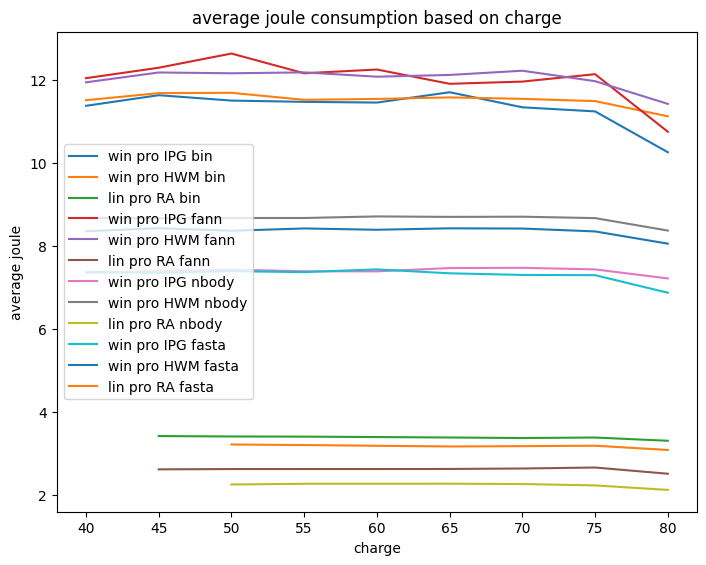

In [36]:
used_duts = [SURFACE_4_PRO]
used_test_cases = test_cases

plot_iterations(CORE_TOTAL,
                get_buckets,
                is_correct_charge,
                "charge",
                "average joule",
                "average joule consumption based on charge",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases=used_test_cases)


In [37]:
intel_power_gadget_data_point = data[SURFACE_4_PRO][WINDOWS_OS][BINARY_TREE][INTEL_POWER_GADGET]["experiment"].experiments[0].time_series.data_point[0]
inspect.getmembers(intel_power_gadget_data_point, lambda a:not(inspect.isroutine(a)))

[('CPUFrequency_0MHz', ' 3200'),
 ('CPUUtilization', '   71.000'),
 ('CumulativeDRAMEnergy_0Joules', '   0.113'),
 ('CumulativeDRAMEnergy_0mWh', '   0.031'),
 ('CumulativeGTEnergy_0Joules', '   0.026'),
 ('CumulativeGTEnergy_0mWh', '   0.007'),
 ('CumulativeIAEnergy_0Joules', '   1.830'),
 ('CumulativeIAEnergy_0mWh', '   0.508'),
 ('CumulativeProcessorEnergy_0Joules', '   2.177'),
 ('CumulativeProcessorEnergy_0mWh', '   0.605'),
 ('DRAMPower_0Watt', '   0.875'),
 ('ElapsedTimesec', '    0.129'),
 ('GTFrequencyMHz', 32),
 ('GTPower_0Watt', '   0.203'),
 ('GTUtilization', '   4.897'),
 ('IAPower_0Watt', '  14.175'),
 ('PackageHot_0', '  0'),
 ('PackagePL1_0Watt', '  25.000'),
 ('PackagePL2_0Watt', '  25.000'),
 ('PackagePL4_0Watt', '  46.000'),
 ('PackageTemperature_0C', ' 68'),
 ('PlatformPsysPL1_0Watt', '  45.000'),
 ('PlatformPsysPL2_0Watt', '  45.000'),
 ('ProcessorPower_0Watt', '  16.871'),
 ('RDTSC', ' 12063536978770'),
 ('SystemTime', '06:49:56:760'),
 ('__class__', utils.objects.

In [38]:
intel_power_gadget_data_point.SystemTime, intel_power_gadget_data_point.CumulativeProcessorEnergy_0Joules

('06:49:56:760', '   2.177')

In [39]:
hardware_monitor_data_point = data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0].time_series.data_point[:10]
inspect.getmembers(hardware_monitor_data_point, lambda a:not(inspect.isroutine(a)))

[('__add__', <method-wrapper '__add__' of list object at 0x00000219E658CE80>),
 ('__class__', list),
 ('__contains__',
  <method-wrapper '__contains__' of list object at 0x00000219E658CE80>),
 ('__delattr__',
  <method-wrapper '__delattr__' of list object at 0x00000219E658CE80>),
 ('__delitem__',
  <method-wrapper '__delitem__' of list object at 0x00000219E658CE80>),
 ('__doc__',
  'Built-in mutable sequence.\n\nIf no argument is given, the constructor creates a new empty list.\nThe argument must be an iterable if specified.'),
 ('__eq__', <method-wrapper '__eq__' of list object at 0x00000219E658CE80>),
 ('__ge__', <method-wrapper '__ge__' of list object at 0x00000219E658CE80>),
 ('__getattribute__',
  <method-wrapper '__getattribute__' of list object at 0x00000219E658CE80>),
 ('__gt__', <method-wrapper '__gt__' of list object at 0x00000219E658CE80>),
 ('__hash__', None),
 ('__iadd__',
  <method-wrapper '__iadd__' of list object at 0x00000219E658CE80>),
 ('__imul__',
  <method-wrapper 

In [40]:
for i in [x for x in data[SURFACE_4_PRO][LINUX_OS][FANNKUCH_REDUX][RAPL]["experiment"].experiments[0].time_series.data_point[:10]]:
    print(i.Core)
    # print(i.CoreTotal)
    print(i.PSys)
    # print(i.PSysTotal)
    print(i.PackageZero)
    # print(i.PackageZeroTotal)
    print("---")

0.0
0.0
0.0
---
1.156979
0.0
1.251828
---
1.215207
0.0
1.383114
---
1.189267
0.0
1.355648
---
1.219052
0.0
1.365292
---
1.175046
0.002197
1.343747
---
1.212949
0.0
1.398128
---
1.207577
0.0
1.381039
---
1.200497
0.0
1.360226
---
1.204343
0.0
1.376828
---


In [41]:
# hardware_monitor_data_point.time, hardware_monitor_data_point.totalLoad

In [42]:
def plot_timestamp(timestamps, values):
    plt.plot(timestamps,values)
    plt.gcf().autofmt_xdate()
    plt.show()

In [43]:
data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0].time_series.data_point[0]

In [44]:
def get_time(x, p):
    if p == INTEL_POWER_GADGET:
        return datetime.strptime(x.SystemTime, "%H:%M:%S:%f")
    elif p == HARDWARE_MONITOR:
        return datetime.strptime(trim_date(x.time), "%Y-%m-%d %H:%M:%S.%f")
    elif p == RAPL:
        return datetime.strptime(trim_date(x.Time), "%Y-%m-%d %H:%M:%S.%f")
    else:
        raise Exception(f"{p} not implemented")

def get_value(x, p):
    if p == INTEL_POWER_GADGET:
        return float(x.ProcessorPower_0Watt)
    elif p == HARDWARE_MONITOR:
        return float(x.cpuPowerPacket)
    elif p == RAPL:
        return float(x.PackageZero)
    else:
        raise Exception(f"{p} not implemented")

def trim_date(date):
    date = date.replace("T", " ")
    date = date.replace("Z", " ")
    return date[:-3]        

def plot_test_case_time_series(d, o, t, p):
    data_points = data[d][o][t][p]["experiment"].experiments[0].time_series.data_point

    timestamps = [get_time(x, p) for x in data_points]
    
    values = []
    last_value = -1
    
    for x in data_points:
        new_value = get_value(x, p)
        
        # if p == RAPL:
        #     if last_value == -1:
        #         last_value = new_value
            
        #     values.append(new_value - last_value)
            
        #     last_value = new_value
        # else:
        values.append(new_value)
        
    
    
    
    # values = [get_value(x, p) for x in data_points]

    plot_timestamp(timestamps, values)
    print(values[:10])

In [45]:
# test_case = IDLE_CASE,
# test_case = BINARY_TREE,
# test_case = FANNKUCH_REDUX,
# test_case = NBODY
test_case = FASTA

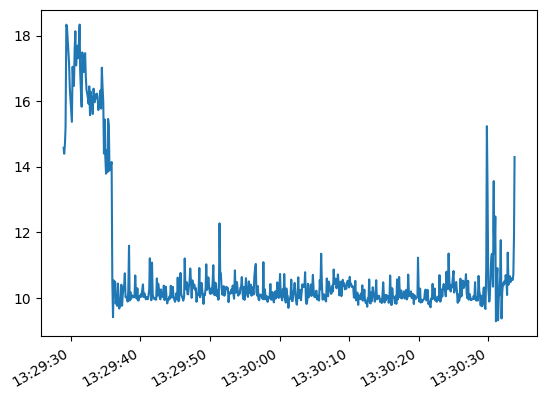

[14.575, 14.396, 14.701, 15.196, 18.332, 18.267, 17.863, 17.54, 17.157, 16.395]


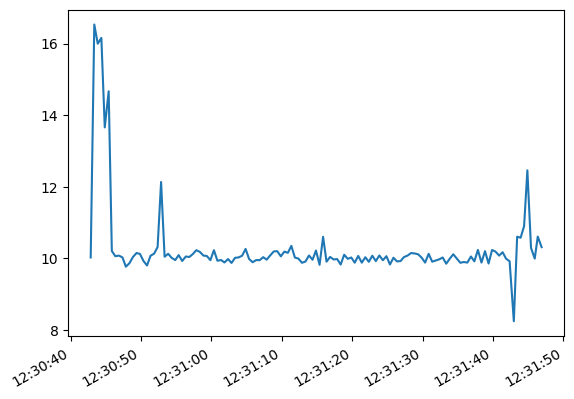

[10.025619, 16.533228, 15.997369, 16.159796, 13.659343, 14.668813, 10.206985, 10.060852, 10.0788, 10.02802]


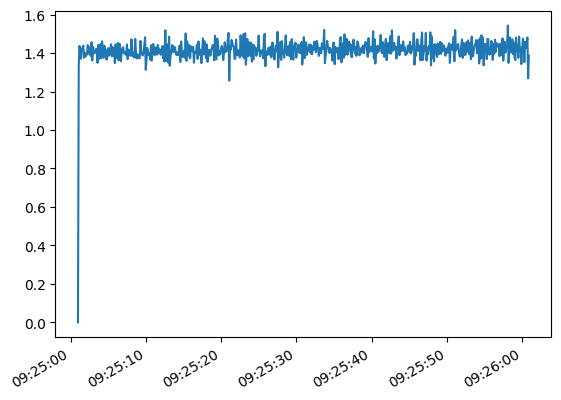

[0.0, 1.336422, 1.437496, 1.408383, 1.370907, 1.423703, 1.41711, 1.438778, 1.376156, 1.402463]


In [46]:
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, HARDWARE_MONITOR)
plot_test_case_time_series(SURFACE_4_PRO, LINUX_OS, test_case, RAPL)

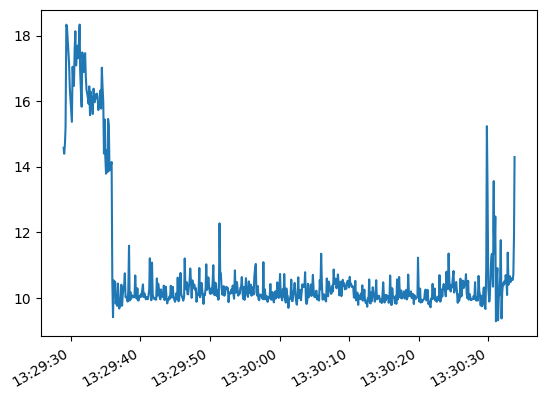

[14.575, 14.396, 14.701, 15.196, 18.332, 18.267, 17.863, 17.54, 17.157, 16.395]


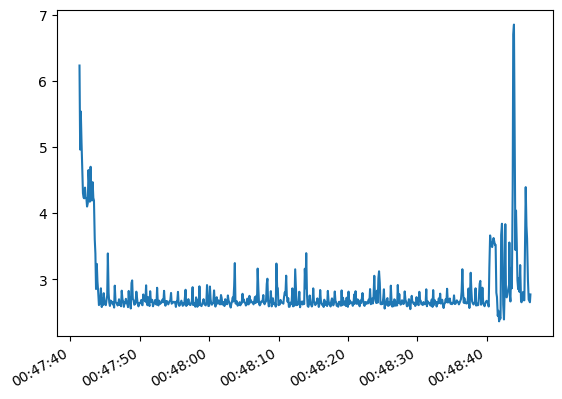

[6.233, 4.963, 5.539, 5.059, 4.726, 4.304, 4.238, 4.226, 4.388, 4.233]


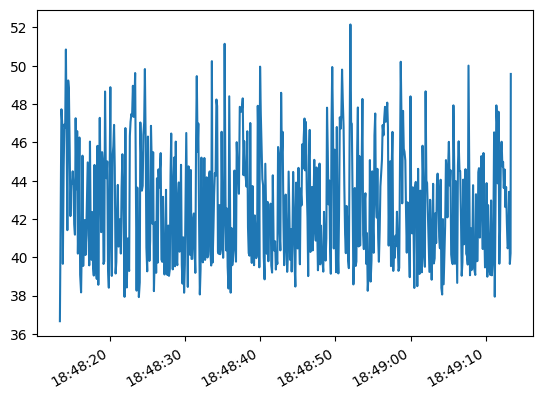

[36.666, 42.026, 47.722, 47.06, 39.66, 44.653, 46.934, 46.759, 50.842, 46.314]


In [47]:
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
plot_test_case_time_series(SURFACE_BOOK, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET)

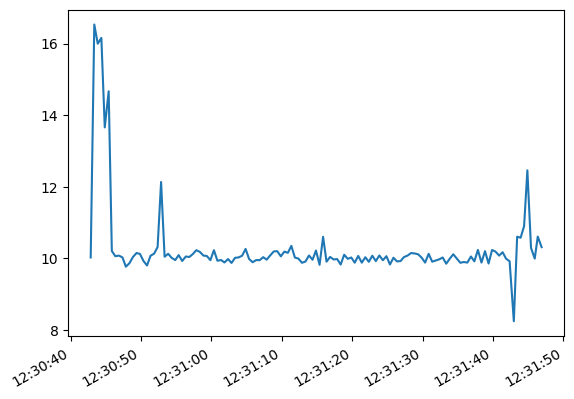

[10.025619, 16.533228, 15.997369, 16.159796, 13.659343, 14.668813, 10.206985, 10.060852, 10.0788, 10.02802]


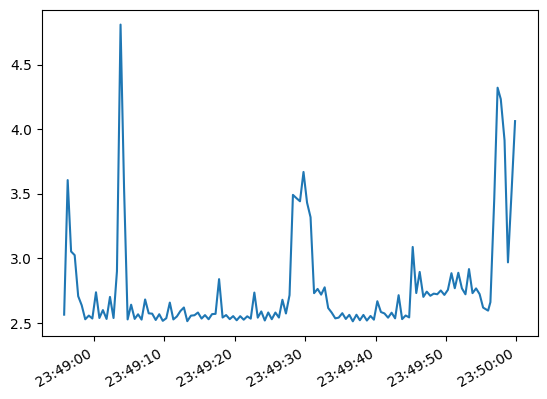

[2.5635817, 3.6057467, 3.0529032, 3.0243545, 2.7066133, 2.6359882, 2.527844, 2.5563436, 2.5336711, 2.736748]


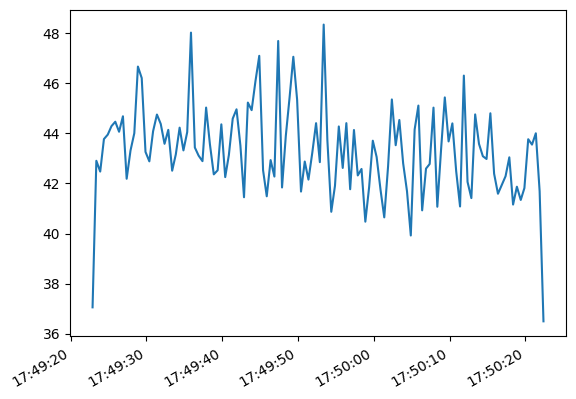

[37.052937, 42.904358, 42.472477, 43.770435, 43.94892, 44.286316, 44.463154, 44.062847, 44.67976, 42.185966]


In [48]:
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, HARDWARE_MONITOR)
plot_test_case_time_series(SURFACE_BOOK, WINDOWS_OS, test_case, HARDWARE_MONITOR)
plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, HARDWARE_MONITOR)

In [49]:
exp = data[SURFACE_BOOK][WINDOWS_OS][FANNKUCH_REDUX][HARDWARE_MONITOR]["experiment"]

In [50]:
inspect.getmembers(exp.experiments[0], lambda a:not(inspect.isroutine(a)))

[('__class__', utils.objects.RawData),
 ('__delattr__',
  <method-wrapper '__delattr__' of RawData object at 0x00000219F2A12680>),
 ('__dict__',
  {'cpuPowerPacketTotalJ': 541.1877729892731,
   'cpuPowerCoresTotalJ': 485.2658758163452,
   'cpuPowerMemoryTotalJ': 42.20328709483147,
   'cpuPowerPacketAverageJ': 4.509898108243942,
   'cpuPowerCoresAverageJ': 4.043882298469543,
   'cpuPowerMemoryAverageJ': 0.3516940591235956,
   'is_valid': True,
   'id': 5307,
   'start_time': datetime.datetime(2022, 11, 20, 3, 46, 3, 74330),
   'end_time': datetime.datetime(2022, 11, 20, 3, 47, 3, 196862),
   'runs': 152677,
   'iteration': 12,
   'first_profiler': 'IntelPowerGadget',
   'duration': 60122,
   'time_series': <utils.objects.TimeSeries at 0x219f2a127d0>,
   'has_time_series': True,
   'start_temperature': <utils.objects.Measurements at 0x219f2a13f40>,
   'stop_temperature': <utils.objects.Measurements at 0x219f2a2c220>,
   'start_battery': <utils.objects.Measurements at 0x219f2a2c4c0>,
   '

In [51]:
class ExpDataPoint(object):
    def __init__(self, exp_id, consumption, runs, duration):
        self.exp_id = exp_id
        self.x = consumption/ runs
        self.y = duration / runs
    
    def set_id(self, id):
        self.id = id
    
    def get_tuple(self):
        return (self.x, self.y)

    def set_distance_to_k(self, value):
        self.dist = value

In [52]:
def find_outliers(experiments, k, points_to_look_back, min_sampels=4, show_graphs=False):
    exp_data_points = []
    k = 1

    for e in experiments:
        exp_data_points.append(ExpDataPoint(
            e.id, e.cpuPowerPacketTotalJ, e.runs, e.duration
        ))
    
    # if show_graphs:
    #     plt.scatter(*zip(*(x.get_tuple() for x in exp_data_points)))
    #     plt.show()
    
    for p1 in exp_data_points:
        dists = []
        for p2 in exp_data_points:
            if p1.exp_id == p2.exp_id:
                dists.append(math.inf)
            else:
                dists.append(math.dist(p1.get_tuple(), p2.get_tuple()))
        sorted_by_second = sorted(dists, key=lambda tup: tup)
        p1.set_distance_to_k(sorted_by_second[k])
    
    exp_data_points = sorted(exp_data_points, key=lambda tup: tup.dist)
    
    for i in range(len(exp_data_points)):
        exp_data_points[i].set_id(i)

    if show_graphs:
        plt.scatter(*zip(*((x.id, x.dist) for x in exp_data_points)))
        plt.show()
    
    eps = exp_data_points[-11].dist
    min_sampels = 4
    
    data_arr = np.array([x.get_tuple() for x in exp_data_points])
    
    dbscan = DBSCAN(eps = eps, min_samples = min_sampels)
    pred = dbscan.fit_predict(data_arr)
    anom_index = np.where(pred == -1)
    values = data_arr[anom_index]

    if show_graphs:
        plt.scatter(data_arr[:,0], data_arr[:,1])
        plt.scatter(values[:,0], values[:,1], color='r')
        plt.show()

    points_to_remove = []

    for v in values:
        for e in exp_data_points:
            tup = (v[0], v[1])
            
            if tup == e.get_tuple():
                points_to_remove.append(e)
                break

    print(f"{len(points_to_remove)} points were removed")
                
    # for p in points_to_remove:
    #     print(f"{p.exp_id} - {p.get_tuple()}")
    
    return [x.exp_id for x in points_to_remove]
    
    
    

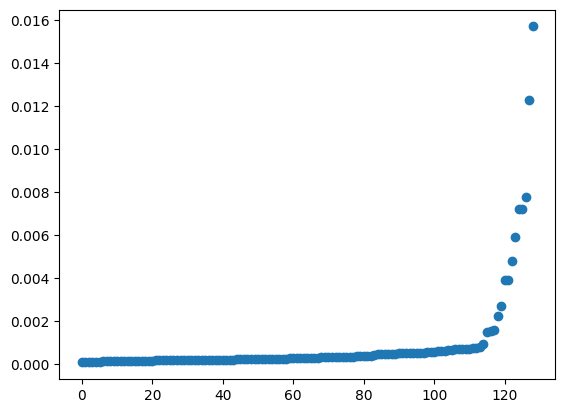

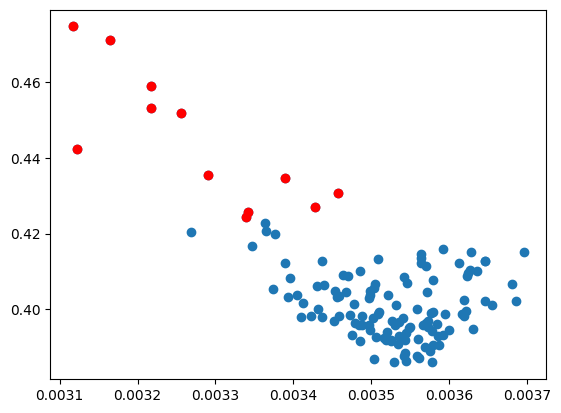

12 points were removed


[4990, 5272, 4755, 4575, 4445, 5001, 4481, 5077, 4918, 5097, 4998, 4521]

In [53]:
o_dut = SURFACE_BOOK
o_os = WINDOWS_OS
o_test_case = FANNKUCH_REDUX
o_profiler = HARDWARE_MONITOR

experiments = data[o_dut][o_os][o_test_case][o_profiler]["experiment"].experiments
k = 4
look_back =11

exp_ids_to_remove = find_outliers(experiments, k, look_back, show_graphs=True)

exp_ids_to_remove

In [56]:
repository = DataRepository()

Connected to MySQL Server version  5.7.39-42-log


In [57]:
version = dut_version[o_dut][o_os]
parameters_for_query = (o_dut, o_os, o_test_case, version, o_profiler)
parameters_for_insert = (k, look_back, o_dut, o_os, o_test_case, version, o_profiler)

repository.parameters_exists(parameters_for_query, repository)
repository.insert_parameters(parameters_for_query, parameters_for_insert, repository)
repository.get_parameters(parameters_for_query, repository)

update


(4, 11)

In [ ]:
exp_data_points = []
k = 1

for e in exp.experiments:
    exp_data_points.append(ExpDataPoint(
        e.id, e.cpuPowerPacketTotalJ, e.runs, e.duration
    ))

In [ ]:
exp_data_points[0].get_tuple(), exp_data_points[0].exp_id

((0.003544658154072146, 0.39378557346555143), 5307)

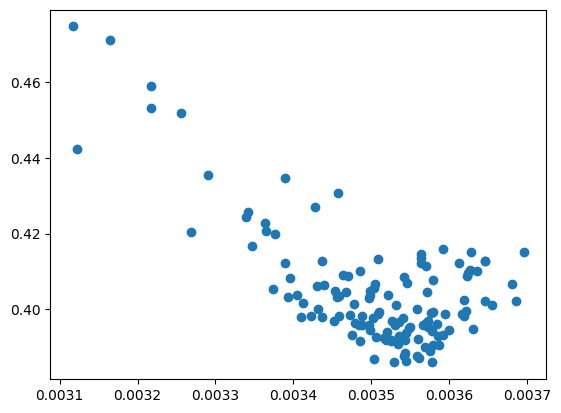

In [ ]:
plt.scatter(*zip(*(x.get_tuple() for x in exp_data_points)))
plt.show()

In [ ]:
math.dist(exp_data_points[0].get_tuple(), exp_data_points[1].get_tuple())

0.009652229981925319

In [ ]:
point_dists = {}

for p1 in exp_data_points:
    dists = []
    for p2 in exp_data_points:
        if p1.exp_id == p2.exp_id:
            dists.append(math.inf)
        else:
            dists.append(math.dist(p1.get_tuple(), p2.get_tuple()))
    sorted_by_second = sorted(dists, key=lambda tup: tup)
    p1.set_distance_to_k(sorted_by_second[k])


In [ ]:
exp_data_points[0].dist

0.0004972922686866513

In [ ]:
exp_data_points = sorted(exp_data_points, key=lambda tup: tup.dist)

len(exp_data_points), [x.dist for x in exp_data_points[:10]]

(129,
 [6.717011522948937e-05,
  8.576326245496345e-05,
  8.576326245496345e-05,
  9.04829743591826e-05,
  0.00010581490082545568,
  0.00010763529696178536,
  0.00011415547559565207,
  0.00011960794287094158,
  0.00012483378447468183,
  0.00012749008325107142])

In [ ]:
for i in range(len(exp_data_points)):
    exp_data_points[i].set_id(i)

[x.id for x in exp_data_points[:10]]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

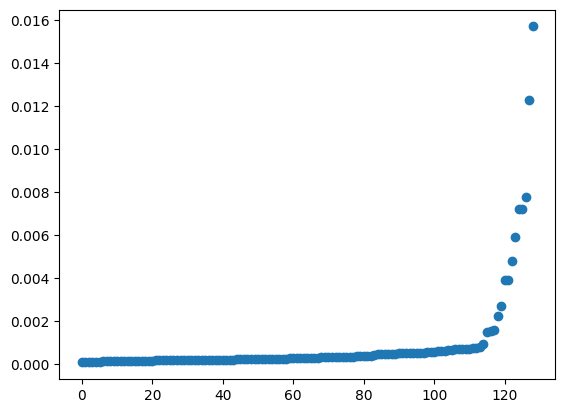

In [ ]:
# plt.scatter(data_arr[:,0], data_arr[:,1])
plt.scatter(*zip(*((x.id, x.dist) for x in exp_data_points)))
plt.show()

In [ ]:
eps = exp_data_points[-11].dist
min_sampels = 4

eps, min_sampels

(0.0022544371189891195, 4)

In [ ]:
data_arr = np.array([x.get_tuple() for x in exp_data_points])

In [ ]:
# dbscan = DBSCAN(eps = 0.28, min_samples = 20)
dbscan = DBSCAN(eps = eps, min_samples = min_sampels)
print(dbscan) 

DBSCAN(eps=0.0022544371189891195, min_samples=4)


In [ ]:


pred = dbscan.fit_predict(data_arr)
anom_index = np.where(pred == -1)
values = data_arr[anom_index]

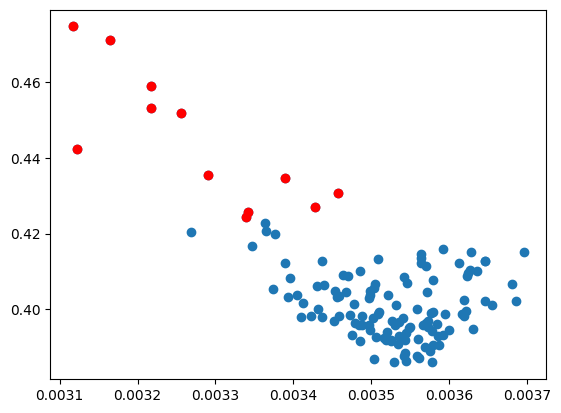

(12, 129)

In [ ]:
plt.scatter(data_arr[:,0], data_arr[:,1])
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()

len(values), len(data_arr)

In [ ]:
points_to_remove = []

for v in values:
    for e in exp_data_points:
        tup = (v[0], v[1])
        
        if tup == e.get_tuple():
            points_to_remove.append(e)
            break

In [ ]:
for p in points_to_remove:
    print(f"{p.exp_id} - {p.get_tuple()}")

4990 - (0.0033416033329553407, 0.4256537682821504)
5272 - (0.0033395049209329736, 0.42440329537673044)
4755 - (0.0034273568952204003, 0.42711722335090285)
4575 - (0.0033896777840704286, 0.43462606281450633)
4445 - (0.0034568112627878654, 0.43072000229072116)
5001 - (0.0032898677174010805, 0.4354867903764145)
4481 - (0.003217897927827825, 0.4530930903774708)
5077 - (0.00325558437927048, 0.4517880884241837)
4918 - (0.003217924444008758, 0.4589893811790553)
5097 - (0.003122721568218636, 0.4423910244620195)
4998 - (0.0031642723532063427, 0.4712577054727459)
4521 - (0.0031172565528596844, 0.47470033638129533)
